# Creating comet models

In [1]:
import os, sys
sys.path.insert(1,'/Users/azib/Documents/open_source/nets/scripts/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets/stella/')

import numpy as np
import build_synthetic_set as models
from utils import *
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

## TESS S28 lightcurves
- S28 is taken as random test sample.
- 2-minute SPOC data.
- Possibly we'll need to generate models for each sector to account for the sector-related noise properties?

- Caveat: the flares dataset sets the "start times" of the flare, we have it set as the midtransit point.

### Generate the models

In [2]:
files = glob('../data/**/*.fits', recursive=True)
len(files)

4247

In [3]:
files[0:5]

['../data/data/target/0000/0001/5608/4371/hlsp_tess-spoc_tess_phot_0000000156084371-s0028_tess_v1_lc.fits',
 '../data/data/target/0000/0001/4147/9660/hlsp_tess-spoc_tess_phot_0000000141479660-s0028_tess_v1_lc.fits',
 '../data/data/target/0000/0001/4147/1290/hlsp_tess-spoc_tess_phot_0000000141471290-s0028_tess_v1_lc.fits',
 '../data/data/target/0000/0001/4147/3159/hlsp_tess-spoc_tess_phot_0000000141473159-s0028_tess_v1_lc.fits',
 '../data/data/target/0000/0001/4147/0373/hlsp_tess-spoc_tess_phot_0000000141470373-s0028_tess_v1_lc.fits']

In [28]:
os.makedirs('../models/',exist_ok=True)
fails = []
times = []
for i in tqdm(files):
    lc, info = import_lightcurve(i)
    # selects a random start time to inject the comet
    t0 = np.random.uniform(lc['TIME'][0],lc['TIME'][-1])
    A = 10 ** np.random.uniform(-3.5, -2, 1)[0]
    
    model = 1-models.comet_curve(lc['TIME'],A,t0)
    
    flux = model * lc['SAP_FLUX']
    flux = flux/np.nanmedian(lc['SAP_FLUX'])
    fluxerror = np.array(lc['SAP_FLUX_ERR']/np.nanmedian(lc['SAP_FLUX']))

    time = np.array(lc['TIME'])
    flux = np.array(flux)
    np.save(f"../models/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
    times.append(t0)

 23%|██████████████████▌                                                             | 983/4247 [00:25<01:19, 41.30it/s]WARNING: VerifyWarning: Error validating header for HDU #1 (note: Astropy uses zero-based indexing).
    Header size is not multiple of 2880: 2432
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
 23%|██████████████████▌                                                             | 983/4247 [00:25<01:23, 39.10it/s]


IndexError: list index out of range

---

## Sanity check: Read in flare models and plot grid
- numpy files are time, flux (normalised), flux error

In [30]:
flares = glob('../stella-tests/lc/*.npy')
flares[0:5]

['../stella-tests/lc/197757864_sector01.npy',
 '../stella-tests/lc/279055830_sector02.npy',
 '../stella-tests/lc/002760232_sector02.npy',
 '../stella-tests/lc/364302118_sector02.npy',
 '../stella-tests/lc/246861224_sector02.npy']

In [31]:
stellas = np.load('../stella-tests/lc/197757864_sector01.npy')
stellas

array([[1.32530082e+03, 1.32530221e+03, 1.32530360e+03, ...,
        1.35317873e+03, 1.35318012e+03, 1.35318151e+03],
       [1.00055659e+00, 9.87374187e-01, 9.97535467e-01, ...,
                   nan,            nan,            nan],
       [7.57158315e-03, 7.54949823e-03, 7.56265502e-03, ...,
                   nan,            nan,            nan]])

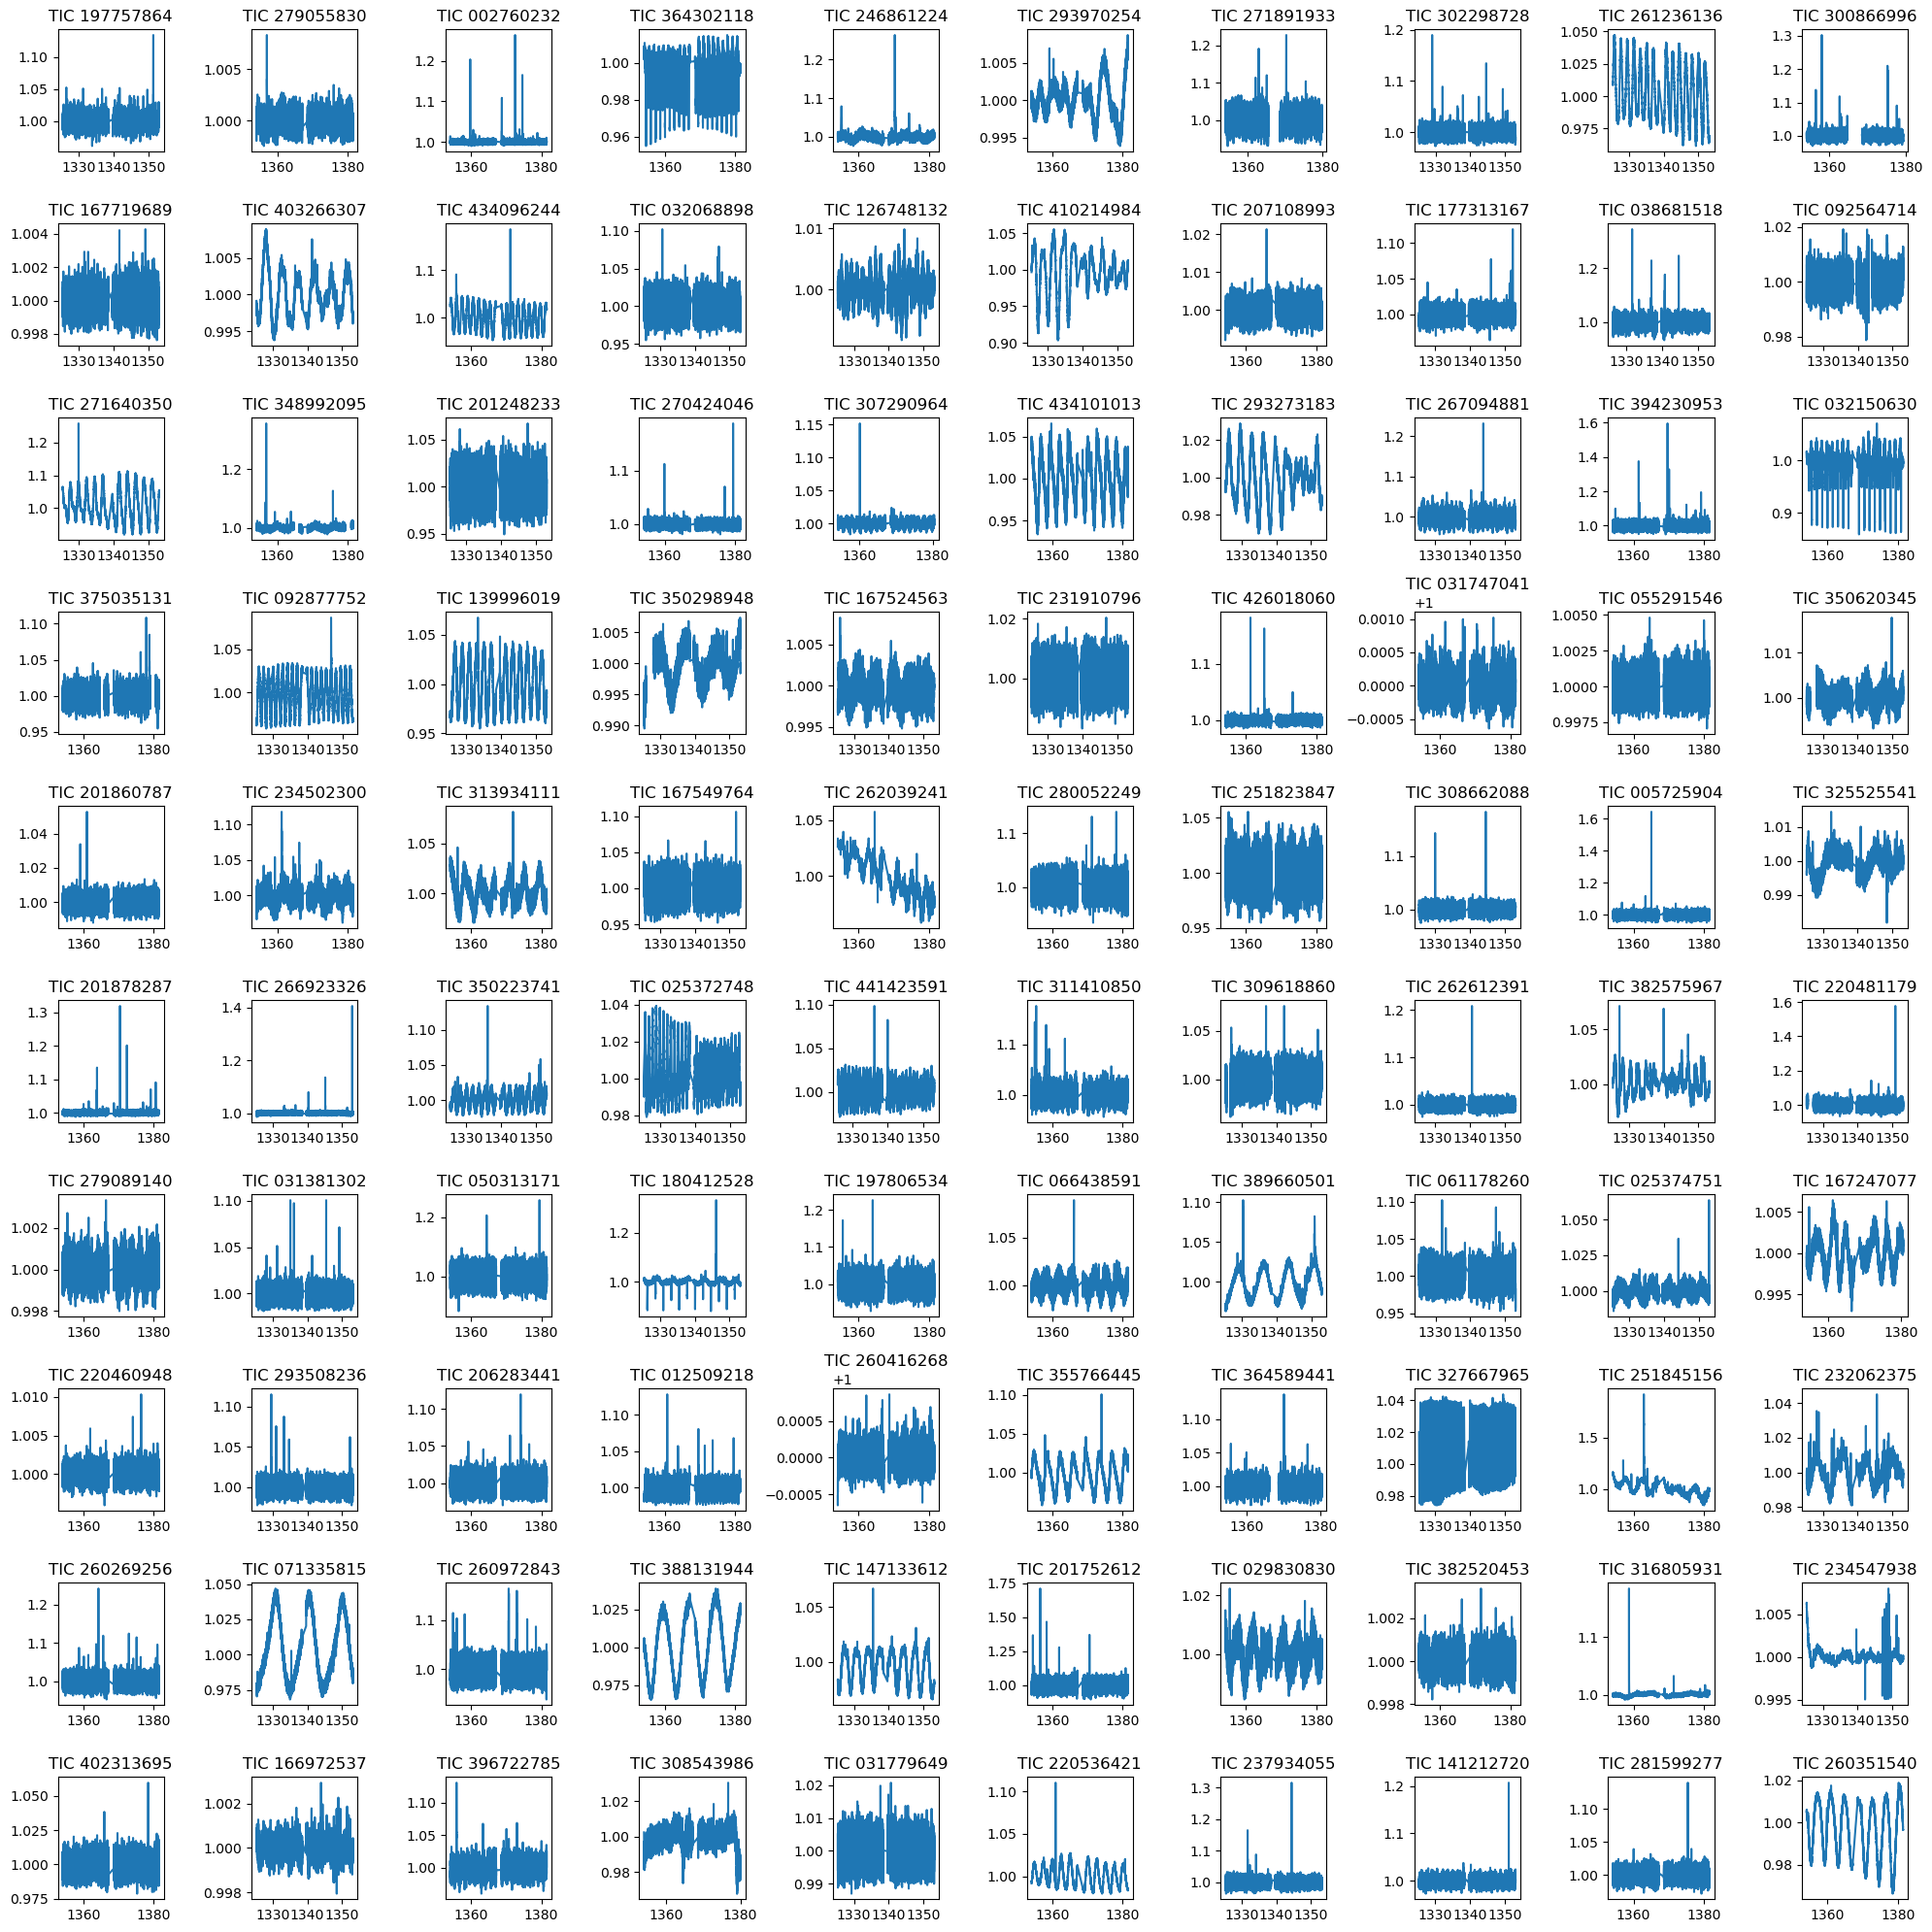

In [16]:
file_paths = glob('../stella-tests/lc/*.npy')

num_files_per_grid = 100

# Loop through the file paths in chunks of num_files_per_grid
for i in range(0, len(file_paths), num_files_per_grid):
    batch_paths = file_paths[i:i+num_files_per_grid]
    num_rows, num_cols = 10, 10
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    for j, path in enumerate(batch_paths):
        file = np.load(path)
        time, flux, fluxerror = file

        # Extract the file ID from the path
        file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

        row = j // num_cols
        col = j % num_cols

        axs[row, col].plot(time, flux)
        axs[row, col].set_title(f'TIC {file_id}')

    plt.tight_layout()
    plt.show()
    break

In [5]:
import stella

/Users/azib/micromamba/envs/nets/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


## Loading comet models

In [29]:
comets =  glob('../models/*.npy')
comets[0:3]

['../models/129637967_sector28.npy',
 '../models/159748170_sector28.npy',
 '../models/129637248_sector28.npy']

### Sample plot of models

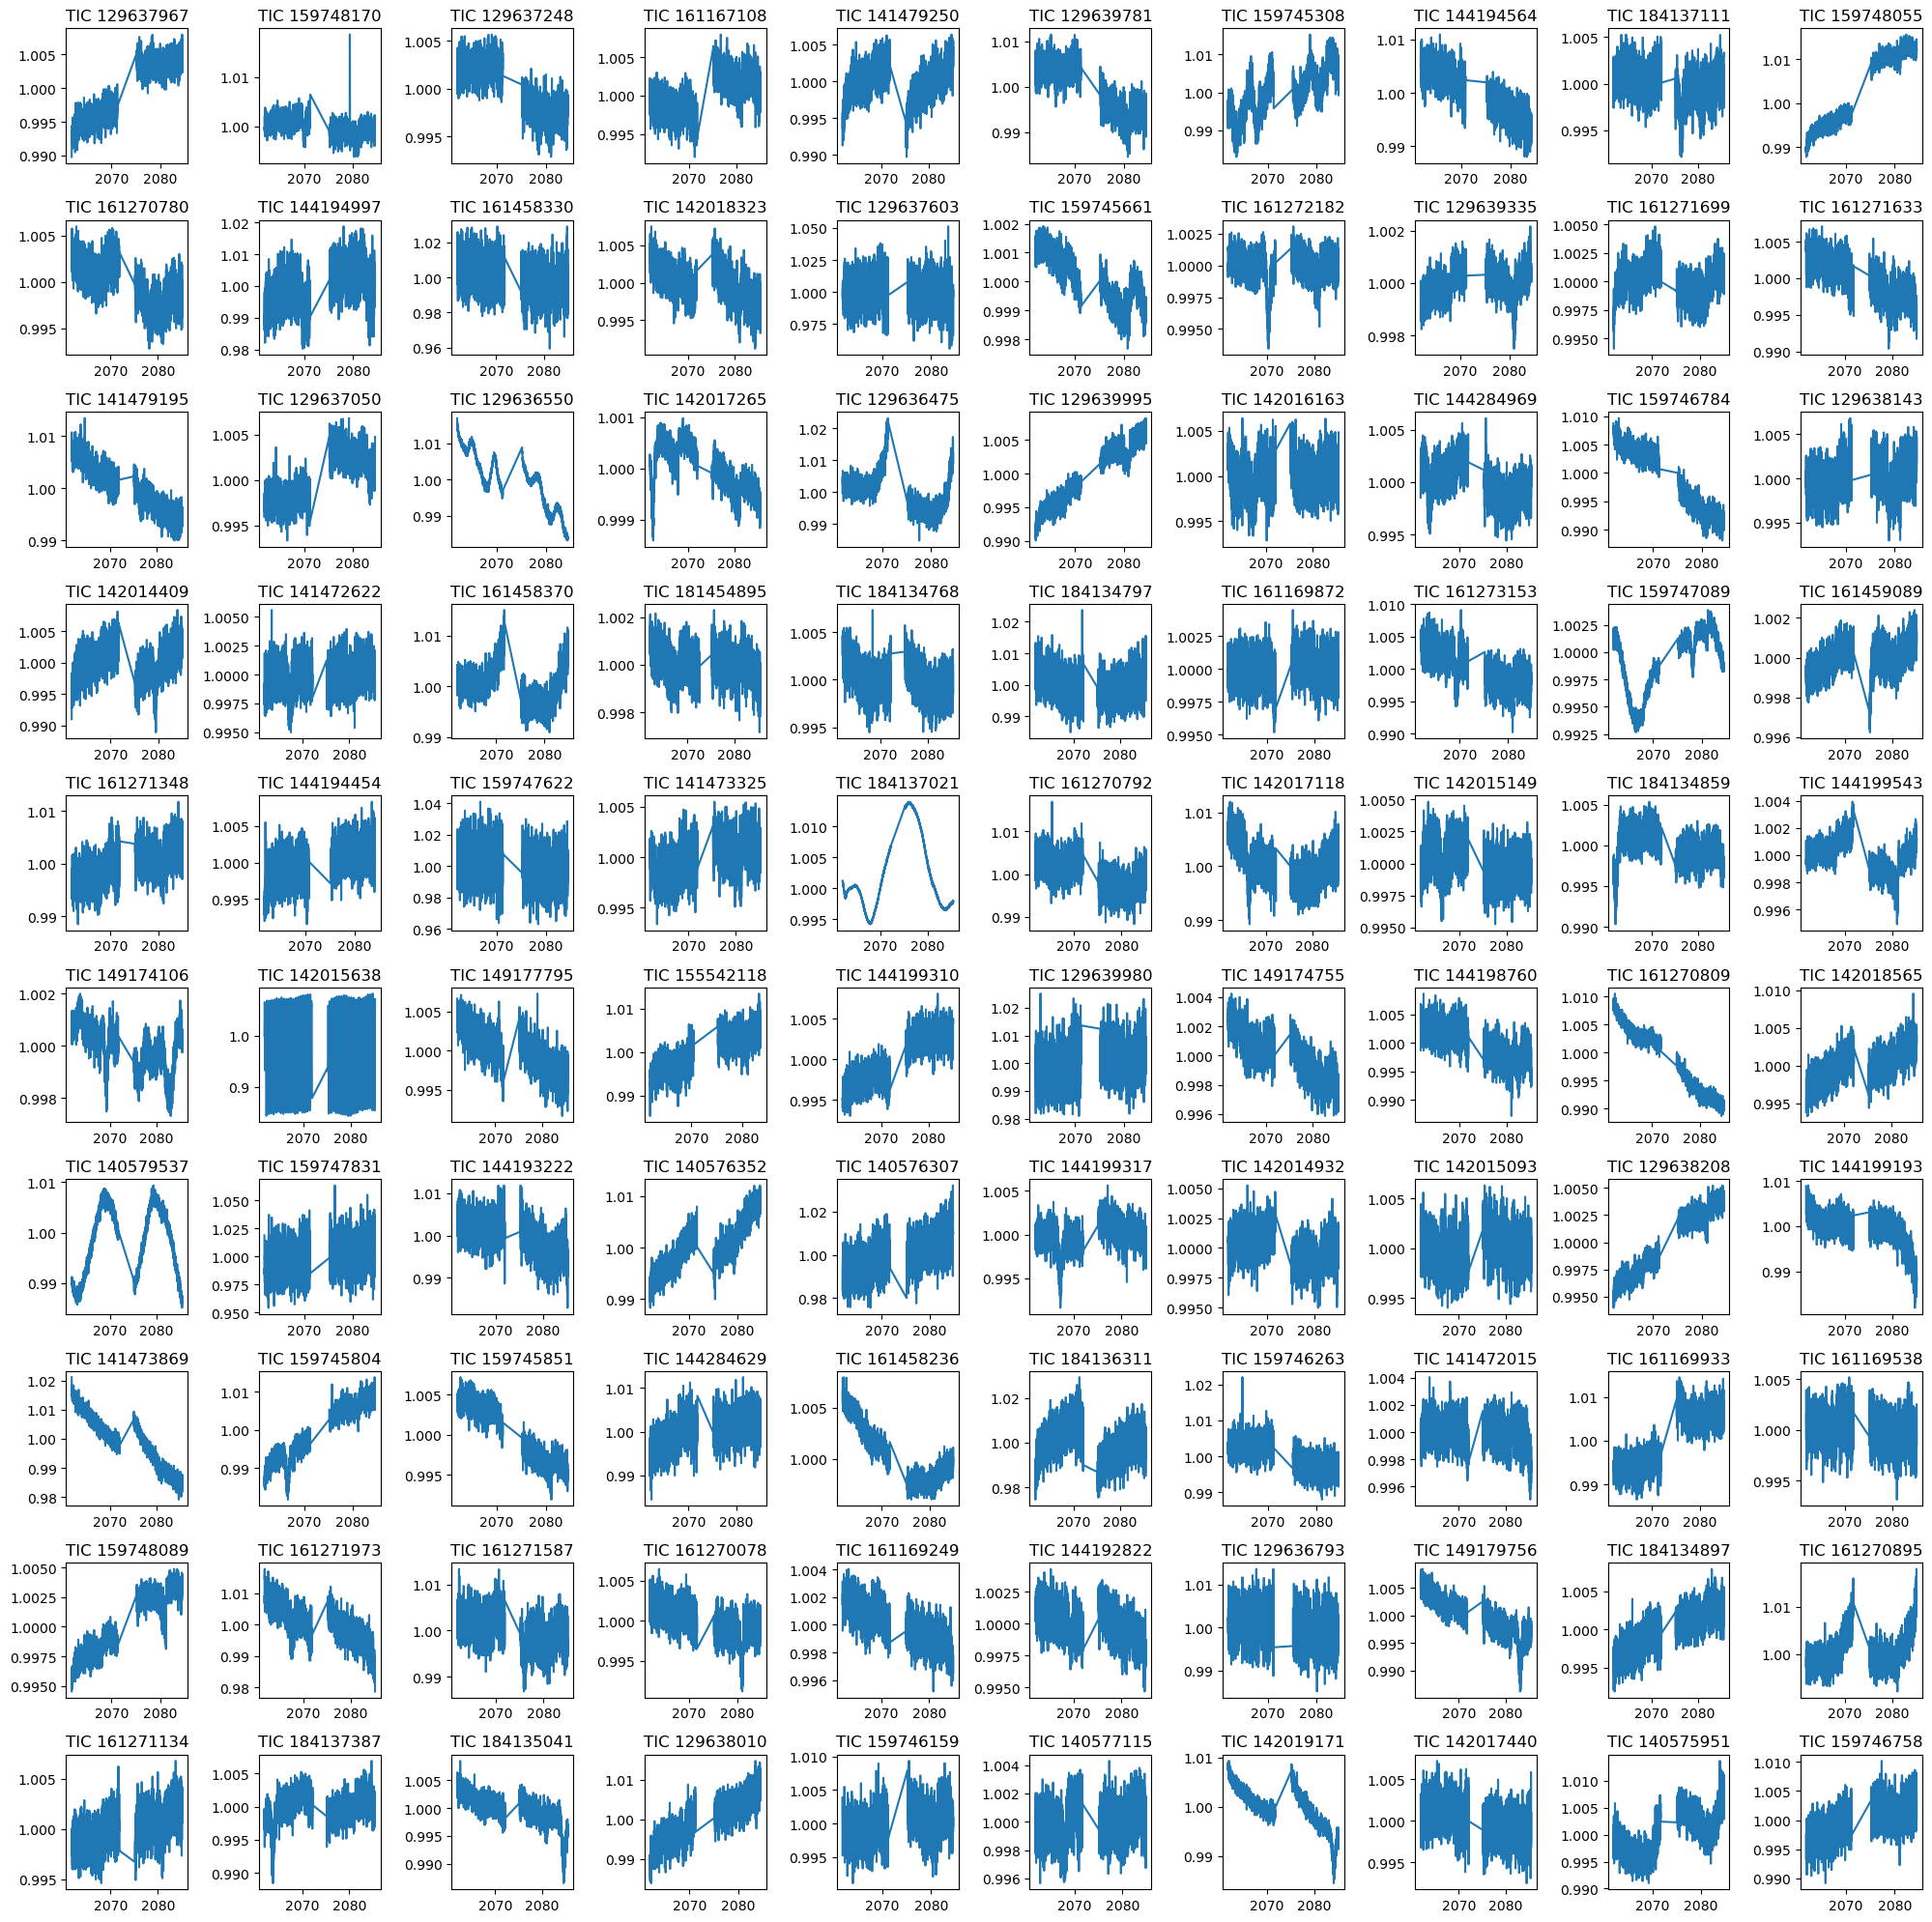

In [136]:
num_files_per_grid = 100

for i in range(0, len(comets), num_files_per_grid):
    batch_paths = comets[i:i+num_files_per_grid]
    num_rows, num_cols = 10, 10
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    for j, path in enumerate(batch_paths):
        file = np.load(path,allow_pickle=True)
        time = file[0]
        flux = file[1]/np.nanmedian(file[1])


        
        # Extract the file ID from the path
        file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]
        

        row = j // num_cols
        col = j % num_cols

        axs[row, col].plot(time, flux)
        axs[row, col].set_title(f'TIC {file_id}')

    plt.tight_layout()
    plt.show()
    break

## Build catalog

In [31]:
tic = [int(path.split('/')[2].split('_')[0]) for path in comets]

In [32]:
from astropy.table import Table

In [33]:
t = Table()
t['TIC'] = tic
t['tpeak'] = times

In [34]:
t.write('catalog-test.txt', format='ascii', overwrite=True) 

In [35]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets/models/',
                         catalog='/Users/azib/Documents/open_source/nets/notebooks/catalog-test.txt')

Reading in training set files.


100%|███████████████████████████████████████████████████████████████████████████████| 983/983 [00:00<00:00, 2295.06it/s]


0 positive classes (flare)
3522 negative classes (no flare)
0.0% class imbalance



hmm, this sho

In [26]:
ds?


Type:           FlareDataSet
String form:    <stella.preprocessing_flares.FlareDataSet object at 0x28fc0b6d0>
File:           ~/Documents/open_source/nets/stella/stella/preprocessing_flares.py
Docstring:     
Given a directory of files, reformat data to
create a training set for the convolutional
neural network.
Files must be in '.npy' file format and contain
at minimum the following indices:
     - 0th index = array of time
     - 1st index = array of flux
     - 2nd index = array of flux errors
All other indices in the files are ignored.
This class additionally requires a catalog of flare
start times for labeling. The flare catalog can be
in either '.txt' or '.csv' file format. This class will
be passed into the stella.neural_network() class to 
create and train the neural network.
Init docstring:
Loads in time, flux, flux error data. Reshapes
arrays into `cadences`-sized bins and labels
flares vs. non-flares using the input catalog.

Parameters
----------
fn_dir : str, optional
    

In [137]:
ds.catalog

TIC,tpeak
int64,float64
129637967,2069.996976668477
159748170,2078.6374247748295
129637248,2079.629512349137
161167108,2073.8525052453188
141479250,2068.204096196406
129639781,2081.4319819600414
159745308,2063.4781567558434
144194564,2071.594031518798
184137111,2083.052533116928


Neat.

### The reformat data function - digging into the code
- Reformat data converts the arrays into the CNN-desired inputs
- Break_rest cuts the lightcurve into cadence-length arrays.

In [131]:
def reformat_data(time, flux, flux_err, tpeaks, cadences=200, random_seed=321):
    ss = 240000
    training_matrix = np.zeros((ss, cadences))
    training_labels = np.zeros(ss, dtype=int)
    training_peaks = np.zeros(ss)
    training_ids = np.zeros(ss)

    x = 0

    for i in tqdm(range(len(time))):
        flares = np.array([], dtype=int)

        if isinstance(tpeaks, (int, float)):
            tpeaks = [tpeaks]
        
        for peak in tpeaks[i]:
            #tpeak is time of event
            arg = np.where((time[i] > (peak - 0.02)) & (time[i] < (peak + 0.02)))[0]
            if len(arg) > 0:
                closest = arg[np.argmin(np.abs(peak - time[i][arg]))]
                start = int(closest - cadences / 2)
                end = int(closest + cadences / 2)
                if start < 0:
                    start = 0
                    end = cadences
                if end > len(time[i]):
                    start = start - (end - len(time[i]))
                    end = len(time[i])
                flare_region = np.arange(start, end, 1, dtype=int)
                flares = np.append(flares, flare_region)

                training_peaks[x] = time[i][closest] + 0.0
                training_ids[x] = ids[i] + 0.0
                training_matrix[x] = flux[i][flare_region]
                training_labels[x] = 1
                x += 1

        time_removed = np.delete(time[i], flares)
        flux_removed = np.delete(flux[i], flares)
        flux_err_removed = np.delete(flux_err[i], flares)

        nontime, nonflux, nonerr = break_rest(time_removed, flux_removed,
                                              flux_err_removed, cadences)
        for j in range(len(nonflux)):
            if x >= ss:
                break
            else:
                training_ids[x] = ids[i] + 0.0
                training_peaks[x] = nontime[j][int(cadences / 2)]
                training_matrix[x] = nonflux[j]
                training_labels[x] = 0
                x += 1

    training_matrix = np.delete(training_matrix, np.arange(x, ss, 1, dtype=int), axis=0)
    labels = np.delete(training_labels, np.arange(x, ss, 1, dtype=int))
    training_peaks = np.delete(training_peaks, np.arange(x, ss, 1, dtype=int))
    training_ids = np.delete(training_ids, np.arange(x, ss, 1, dtype=int))

    ids, matrix, label, peaks = do_the_shuffle(training_matrix, labels, training_peaks,
                                               training_ids, frac_balance)
    return label, peaks, ids, matrix

def break_rest(time, flux, flux_err, cadences):
    """
    Breaks up the non-signal cases into bite-sized cadence-length chunks.

    Parameters
    ----------
    time : np.ndarray
         Array of time.
    flux : np.ndarray
         Array of fluxes.
    flux_err : np.ndarray
         Array of flux errors.
    cadences : int
         Number of cadences for the training-validation-test set.

    Returns
    -------
    time : np.ndarray
         Array of times without the signal.
    flux : np.ndarray
         Array of fluxes without the signal.
    err : np.ndarray
         Array of flux errors without the signal.
    """
    # BREAKING UP REST OF LIGHT CURVE INTO CADENCE SIZED BITES     
    print(type(time))
    diff = np.diff(time)
    breaking_points = np.where(diff > (np.median(diff) + 1.5*np.std(diff)))[0]
    
    tot = 100
    ss  = 1000
    nonflare_time = np.zeros((ss, cadences))
    nonflare_flux = np.zeros((ss, cadences))
    nonflare_err = np.zeros((ss, cadences))
    
    x = 0
    for j in range(len(breaking_points)+1):
        if j == 0:
            start = 0
            end = breaking_points[j]
        elif j < len(breaking_points):
            start = breaking_points[j-1]
            end = breaking_points[j]
        else:
            start = breaking_points[-1]
            end = len(time)

        if np.abs(end-start) > (2*cadences):
            broken_time = time[start:end]
            broken_flux = flux[start:end]
            broken_err  = flux_err[start:end]

            # DIVIDE LIGHTCURVE INTO EVEN BINS                                                                        
            c = 0
            while (len(broken_time) - c) % cadences != 0:
                c += 1

            # REMOVING CADENCES TO BIN EVENLY INTO CADENCES                                                           
            temp_time = np.delete(broken_time, np.arange(len(broken_time)-c,
                                                         len(broken_time), 1, dtype=int) )
            temp_flux = np.delete(broken_flux, np.arange(len(broken_flux)-c,
                                                         len(broken_flux), 1, dtype=int) )
            temp_err = np.delete(broken_err, np.arange(len(broken_err)-c,
                                                       len(broken_err), 1, dtype=int) )

            # RESHAPE ARRAY FOR INPUT INTO MATRIX                                                                     
            temp_time = np.reshape(temp_time,
                                   (int(len(temp_time) / cadences), cadences) )
            temp_flux = np.reshape(temp_flux,
                                   (int(len(temp_flux) / cadences), cadences) )
            temp_err  = np.reshape(temp_err,
                                   (int(len(temp_err) / cadences), cadences) )
            
            # APPENDS TO BIGGER MATRIX                                                                                
            for f in range(len(temp_flux)):
                if x >= ss:
                    break
                else:
                    nonflare_time[x] = temp_time[f]
                    nonflare_flux[x] = temp_flux[f]
                    nonflare_err[x] = temp_err[f]
                    x += 1

    nonflare_time = np.delete(nonflare_time, np.arange(x, ss, 1, dtype=int), axis=0)
    nonflare_flux = np.delete(nonflare_flux, np.arange(x, ss, 1, dtype=int), axis=0)
    nonflare_err  = np.delete(nonflare_err,  np.arange(x, ss, 1, dtype=int), axis=0)
    
    return nonflare_time, nonflare_flux, nonflare_err

In [132]:
c = t[0:5]
comets[0:5]

['../models/129637967_sector28.npy',
 '../models/159748170_sector28.npy',
 '../models/129637248_sector28.npy',
 '../models/161167108_sector28.npy',
 '../models/141479250_sector28.npy']

In [133]:
test = np.load('../models/129637967_sector28.npy',allow_pickle=True)

In [134]:
test[0]

array([2061.86331291, 2061.87025738, 2061.87720184, ..., 2084.50188236,
       2084.5088266 , 2084.51577083])

In [135]:
reformat_data(test[0],test[1],test[2],tpeaks=[t[0]['tpeak']])

  0%|                                                                                          | 0/2683 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object is not iterable

In [128]:
np.array(t[0]['tpeak'])

array(2069.99697667)